# Convnet Model and Training

This aim of notebook is to define the siamese model that will be used for the Humpback Whale challenge. It will also run the model to trainin it agains our previously generated training and validation dataset and also create the results agains a test dataset.

## 0. Module Imports 

In [184]:
import numpy as np
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

## 1. Load Training, Validation and Test datasets

In [185]:
pickle_file = '../data/Siamese_dataset.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X1_dataset = save['train_X1_dataset']
    train_X2_dataset = save['train_X2_dataset']
    train_labels = save['train_labels']
    valid_X1_dataset = save['valid_X1_dataset']
    valid_X2_dataset = save['valid_X2_dataset']
    valid_labels = save['valid_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_X1_dataset.shape, train_X2_dataset.shape, train_labels.shape)
    print('Validation set', valid_X1_dataset.shape, valid_X2_dataset.shape, valid_labels.shape)

Training set (31218, 44, 100) (31218, 44, 100) (31218,)
Validation set (5510, 44, 100) (5510, 44, 100) (5510,)


##  2. Declaration of Global Constants
Now we declare all the global constants in hee in orde to have them centralized.
This way we can easyly tune our model.

In [186]:
## Image parameters
NUM_CHANNELS = 1
IMAGE_HEIGHT = 44
IMAGE_WIDHT = 100

#Convnet parameters
BETA = 0.005
PATCH_1 = 7
PATCH_2 = 6
DEPTH_1 = 15
DEPTH_2 = 45
NUM_HIDEN = 1024
NUM_LABELS = 1
MARGIN = 5.0


#Training parameters
BATCH_SIZE = 128
NUM_STEPS = 1501

## 3. Reformat datasets into a TensorFlow-friendly shape:

- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.



In [187]:
num_labels = 1

def reformat(dataset1, dataset2, labels):
  dataset1 = dataset1.reshape(
    (-1, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS)).astype(np.float32)
  dataset2 = dataset2.reshape(
    (-1, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset1, dataset2, labels
train_X1_dataset, train_X2_dataset, train_labels = reformat(train_X1_dataset, train_X2_dataset, train_labels)
valid_X1_dataset, valid_X2_dataset, valid_labels = reformat(valid_X1_dataset, valid_X2_dataset, valid_labels)
print('Training set', train_X1_dataset.shape, train_X2_dataset.shape, train_labels.shape)
print('Validation set', valid_X1_dataset.shape, valid_X2_dataset.shape, valid_labels.shape)

Training set (31218, 44, 100, 1) (31218, 44, 100, 1) (31218, 1)
Validation set (5510, 44, 100, 1) (5510, 44, 100, 1) (5510, 1)


## 4. Definition of auxiliar functions

### 4.1. Accuracy computation

In [192]:
def accuracy(predictions, labels):
    aux = predictions < MARGIN
    equal = np.equal(aux[:] , labels[:, 0])
    great = np.greater(aux[:] , labels[:, 0])
    less = np.less(aux[:] , labels[:, 0])
    acc = (100.0 * np.sum(equal.astype(np.float32))
          / predictions.shape[0])
    false_pos = np.sum(great.astype(np.float32))
    false_neg = np.sum(less.astype(np.float32))
    return acc, false_pos, false_neg

## 5. Network declaration
We will use tensorflow

In [203]:

siamese_model = tf.Graph()

with siamese_model.as_default():

  # Input data.
    tf_train_X1_dataset = tf.placeholder(\
          tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS))
    tf_train_X2_dataset = tf.placeholder(\
          tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_X1_dataset = tf.constant(valid_X1_dataset)
    tf_valid_X2_dataset = tf.constant(valid_X2_dataset)
    #tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = {
      'layer1': tf.Variable(tf.truncated_normal(\
              [PATCH_1, PATCH_1, NUM_CHANNELS, DEPTH_1], stddev=0.1)),
      'layer2': tf.Variable(tf.truncated_normal(\
              [PATCH_2, PATCH_2, DEPTH_1, DEPTH_2], stddev=0.1)),
      'layer3': tf.Variable(tf.truncated_normal(\
              [IMAGE_HEIGHT // 4 * IMAGE_WIDHT // 4 * DEPTH_2, NUM_HIDEN], stddev=0.1)),
      'layer4': tf.Variable(tf.truncated_normal(\
              [NUM_HIDEN, 10], stddev=0.1))
      }
    biases = {
        'layer1' : tf.Variable(tf.zeros([DEPTH_1])),
        'layer2' : tf.Variable(tf.constant(1.0, shape=[DEPTH_2])),
        'layer3' : tf.Variable(tf.constant(1.0, shape=[NUM_HIDEN])),
        'layer4' : tf.Variable(tf.constant(1.0, shape=[1]))
        }
  
  # Model.
    def model(data):
        conv = tf.nn.conv2d(data, weights['layer1'], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['layer1'])
        conv = tf.nn.conv2d(hidden, weights['layer2'], [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['layer2'])
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, weights['layer3']) + biases['layer3'])
        return tf.matmul(hidden, weights['layer4']) + biases['layer4']
    
    
  # Training computation.
    with tf.variable_scope("siamese") as scope:
        logits1 = model(tf_train_X1_dataset)
        scope.reuse_variables()
        logits2 = model(tf_train_X2_dataset)
        
    with tf.variable_scope("siamese_val") as scope:
        val_logits1 = model(tf_valid_X1_dataset)
        scope.reuse_variables()
        val_logits2 = model(tf_valid_X2_dataset)
        
    def loss(y):
        labels_t = y
        labels_f = tf.subtract(1.0, y, name="1-yi")          # labels_ = !labels;
        eucd2 = tf.pow(tf.subtract(logits1, logits2), 2)
        eucd2 = tf.reduce_sum(eucd2, 1)
        eucd = tf.sqrt(eucd2+1e-6, name="eucd")
        C = tf.constant(MARGIN, name="C")
        # yi*||CNN(p1i)-CNN(p2i)||^2 + (1-yi)*max(0, C-||CNN(p1i)-CNN(p2i)||^2)
        pos = tf.multiply(labels_t, eucd2, name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.subtract(0.0,eucd2), name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C,eucd2)), name="Nyi_x_C-eucd_xx_2")
        neg = tf.multiply(labels_f, tf.pow(tf.maximum(tf.subtract(C, eucd), 0), 2), name="Nyi_x_C-eucd_xx_2")
        losses = tf.add(pos, neg, name="losses")
        loss = tf.reduce_mean(losses, name="loss")
        return loss
        
    loss = loss(tf_train_labels)
    
  # Optimizer.
    optimizer = tf.train.AdamOptimizer().minimize(loss)
  
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.reduce_sum(tf.pow(tf.subtract(logits1, logits2), 2),1)
    print(train_prediction.shape)
    valid_prediction = tf.reduce_sum(tf.pow(tf.subtract(val_logits1, val_logits2), 2),1)
    print(valid_prediction.shape)
    #test_prediction = tf.nn.softmax(model(tf_test_dataset))


(128,)
(5510,)


## 6. Model training

Initialized
Minibatch loss at step 0 84.7983093262
Minibatch accuracy: 48.4375 false positives: 0.0 false negatives: 66.0
Validation accuracy: 46.442831216 false positives: 23.0 false negatives: 2928.0
Minibatch loss at step 50 8.81370925903
Minibatch accuracy: 35.9375 false positives: 11.0 false negatives: 71.0
Validation accuracy: 42.7404718693 false positives: 608.0 false negatives: 2547.0
Minibatch loss at step 100 6.88838577271
Minibatch accuracy: 35.9375 false positives: 35.0 false negatives: 47.0
Validation accuracy: 45.0816696915 false positives: 1068.0 false negatives: 1958.0
Minibatch loss at step 150 6.7901134491
Minibatch accuracy: 38.28125 false positives: 31.0 false negatives: 48.0
Validation accuracy: 44.9183303085 false positives: 1313.0 false negatives: 1722.0
Minibatch loss at step 200 6.78271198273
Minibatch accuracy: 51.5625 false positives: 27.0 false negatives: 35.0
Validation accuracy: 45.335753176 false positives: 1385.0 false negatives: 1627.0
Minibatch loss at

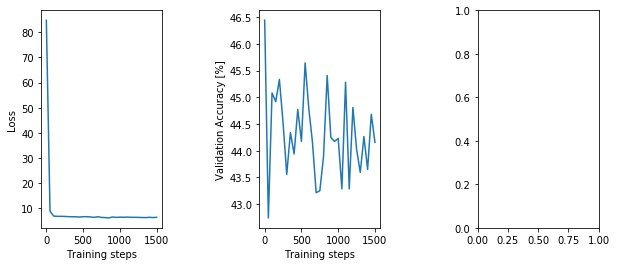

In [204]:
#Plots
P_FREQ = 50
losses = []
accuracies = []
rates = []

with tf.Session(graph=siamese_model) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(NUM_STEPS):
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    batch_data_X1 = train_X1_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_data_X2 = train_X2_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
    feed_dict = {tf_train_X1_dataset : batch_data_X1, tf_train_X2_dataset : batch_data_X2, \
                 tf_train_labels : batch_labels}
    _, _loss, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if np.isnan(_loss):
        print('Model diverged with loss = NaN')
        quit()
        
    #Plot variables
    if (step % P_FREQ == 0):
      losses.append(_loss)
      hey= valid_prediction.eval()
      accuracies.append(accuracy(valid_prediction.eval(), valid_labels)[0])
    
    if (step % 50 == 0):
      print('Minibatch loss at step {} {}'.format(step, _loss))
      a = accuracy(predictions, batch_labels)
      print('Minibatch accuracy: {} false positives: {} false negatives: {}'.format(a[0], a[1], a[2] ) )
      a = accuracy(valid_prediction.eval(), valid_labels)
      print('Validation accuracy: {} false positives: {} false negatives: {}'.format(a[0], a[1], a[2] ) )
#print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

# Show the results.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=.8)
fig.set_size_inches(10, 4)
ax1.plot(range(0, NUM_STEPS, P_FREQ), losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")
ax2.plot(range(0, NUM_STEPS, P_FREQ), accuracies)
ax2.set_ylabel("Validation Accuracy [%]")
ax2.set_xlabel("Training steps")
plt.show()


In [ ]:
print(valid_labels.shape)

In [124]:
print(predictions.shape)

(128,)


In [125]:
print(hey)

[ 6.11904621  7.43290091  7.31785154 ...,  9.63284588  7.26450729
  4.35797882]


In [126]:
a = hey < 5.0
print(a.astype(np.float32))

[ 0.  0.  0. ...,  0.  0.  1.]


In [161]:
print(_valid_labels)
print(valid_labels)

[ 1.  1.  1. ...,  1.  0.  0.]
[[ 1.]
 [ 1.]
 [ 1.]
 ..., 
 [ 1.]
 [ 0.]
 [ 0.]]


In [130]:
print(a[23].astype(np.float32))
print(valid_labels[23])

0.0
[ 1.]


In [199]:
def accuracy_dbg(predictions, labels, print_nr = 0):
    aux = predictions < MARGIN
    equal = np.equal(aux[:] , labels[:,0])
    print(predictions[print_nr])
    print(labels[print_nr])
    print(aux[print_nr].astype(np.float32))
    print(aux.shape)
    print(labels.shape)
    print(equal.shape)
    print(predictions.shape)
    acc = (100.0 * np.sum(equal.astype(np.float32))
          / predictions.shape[0])
    false_pos = 12
    false_neg = 122
    return acc, false_pos, false_neg
a = accuracy_dbg(hey, valid_labels, 24)
print(a)
print(" {} {} {}".format(a[0], a[1], a[2]))

5906.37
[ 1.]
0.0
(5510,)
(5510, 1)
(5510,)
(5510,)
(46.678765880217789, 12, 122)
 46.6787658802 12 122
